# Import

In [30]:
import json
import io
import tensorflow as tf
from google.colab import drive
from colabtools import drive
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


import tensorflow as tf
import numpy as np


import io

In [2]:
tf.__version__

'2.17.0'

# To dataset function

In [3]:
def df_to_dataset(dataframe, feature_dict, buffer_size=None, shuffle=True, batch_size=32):
    """
    buffer_size is for shuffle.
    Bigger buffer_size means everything needs to be in memory then only shuffle.
    Smaller is faster but less random
    """
    labels = dataframe["target"]
    df = {}
    for key, cols in feature_dict.items():
        if key in ["num_vars_norm", "num_vars"]:
            df[key] = dataframe[cols]
        else:
            for col in cols:
                df[col] = dataframe[col].tolist()
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

# Load data

In [4]:
from google3.pyglib import gfile
import json


raw = drive.LoadFile(file_id='1BDcJ5xbi7_92x12yoz31ocmgSP9hP5Yc')

with io.BytesIO(raw) as f:
  feature_dict_3 = json.load(f)

Beginning OAuth2 authorization process ...
Authentication successful.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
lengths = {key: len(value) for key, value in feature_dict_3.items()}
lengths

{'cat_vars_num': 9, 'cat_vars_str': 74, 'num_vars': 3840, 'num_vars_norm': 19}

In [6]:
from colabtools import drive
import io

raw = drive.LoadFile(file_id='1_igRkwmpncmfrroksLxdmX1L0rMnfs2y')
b = io.BytesIO(raw)
model_3_data_big = pd.read_csv(b,keep_default_na=False)
model_3_data_big.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

date_time is_avy_obs  ...  solar_radiation  weather_cond_code
0  2021-04-17         No  ...                                    
1  2021-04-17         No  ...                                    
2  2021-04-17         No  ...                                    
3  2021-04-17         No  ...                                    
4  2021-04-17         No  ...                                    

[5 rows x 3951 columns]

In [7]:
# Should fix these before saving the CSV files

# Replace empty string with -1 for int column
model_3_data_big[feature_dict_3["num_vars_norm"]] = (
    model_3_data_big[feature_dict_3["num_vars_norm"]].replace("", -1).astype(float).astype(int)
)

# Maybe it's okay to keep these
column_to_drop = ['lat', 'lng', 'lat_lng', 'STID', 'Latitude', 'Longitude']
model_3_data_big.drop(columns=column_to_drop, inplace=True)
model_3_data_big.shape

# Can do this before saving the CSV (optional)
model_3_data_big['target'] = model_3_data_big['is_avy_obs'].replace({'Yes': 1, 'No': 0})

In [12]:
cutoff_date = '2022-06-01'
train_r = model_3_data_big[model_3_data_big['date_time'] < cutoff_date].drop(columns=['date_time', 'is_avy_obs'])
train_r, val_r = train_test_split(train_r,  test_size=0.2, random_state=42)
test_r = model_3_data_big[model_3_data_big['date_time'] >= cutoff_date].drop(columns=['date_time', 'is_avy_obs'])

print(train_r.shape)
print(val_r.shape)
print(test_r.shape)

(3071, 3944)
(768, 3944)
(2452, 3944)


In [13]:
feature_dict_wo_dup = {}

for key, ori_cols in feature_dict_3.items():
    feature_dict_wo_dup[key] = []
    for col in ori_cols:
        # Should drop these
        if train_r[col].nunique() != 1:
            feature_dict_wo_dup[key].append(col)
        else:
            print(f'{col} is all unique value. Should drop from feature_dict_3')

air_temp_high_24_hour is all unique value. Should drop from feature_dict_3
air_temp_high_6_hour is all unique value. Should drop from feature_dict_3
air_temp_low_24_hour is all unique value. Should drop from feature_dict_3
air_temp_low_6_hour is all unique value. Should drop from feature_dict_3
dew_point_temperature is all unique value. Should drop from feature_dict_3
precip_accum_one_minute is all unique value. Should drop from feature_dict_3


In [14]:
# This can be slow
batch_size = 128
buffer_size = 4096  # 128 seems to work without buffer refill. 256 needs refill

train_ds_r = df_to_dataset(train_r, feature_dict_wo_dup, buffer_size=buffer_size, batch_size=batch_size)
val_ds_r = df_to_dataset(val_r, feature_dict_wo_dup, shuffle=False, buffer_size=buffer_size, batch_size=batch_size)
test_ds_r = df_to_dataset(test_r, feature_dict_wo_dup, shuffle=False, buffer_size=buffer_size, batch_size=batch_size)

In [15]:
num_vars_norm_input = tf.keras.Input(shape=(len(feature_dict_wo_dup["num_vars_norm"]),), name="num_vars_norm")

num_vars_norm_layer = tf.keras.layers.Normalization(axis=1)
num_vars_norm_layer.adapt(train_r[feature_dict_wo_dup["num_vars_norm"]].values)
num_vars_norm_input_enc = num_vars_norm_layer(num_vars_norm_input)

In [16]:
num_vars_input = tf.keras.Input(shape=(len(feature_dict_wo_dup["num_vars"]),), name="num_vars")
num_vars_enc = tf.keras.layers.Dense(128, activation="relu")(num_vars_input)

In [19]:
cat_vars_str_input = []
cat_vars_str_input_enc = []

for col_name in feature_dict_3["cat_vars_str"]:

    # Should drop these
    if train_r[col_name].nunique() == 1:
        print(f'{col_name} is all unique value. Should drop from feature_dict_3["cat_vars_str"]')
        continue

    each_input = tf.keras.Input(shape=(1,), name=col_name, dtype='string')

    str_lookup_layer = tf.keras.layers.StringLookup(max_tokens=train_r[col_name].nunique())
    str_lookup_layer.adapt(train_r[col_name].values)
    cat_encoder = tf.keras.layers.CategoryEncoding(num_tokens=str_lookup_layer.vocabulary_size())
    each_input_encoded = cat_encoder(str_lookup_layer(each_input))

    cat_vars_str_input.append(each_input)
    cat_vars_str_input_enc.append(each_input_encoded)

In [18]:
cat_vars_num_input = []
cat_vars_num_input_enc = []

for col_name in feature_dict_3["cat_vars_num"]:

    # Should drop these
    if train_r[col_name].nunique() == 1:
        print(f'{col_name} is all unique value. Should drop from feature_dict_3["cat_vars_num"]')
        continue

    each_input = tf.keras.Input(shape=(1,), name=col_name, dtype='int8')

    int_lookup_layer = tf.keras.layers.IntegerLookup(max_tokens=train_r[col_name].nunique())
    int_lookup_layer.adapt(train_r[col_name].values)
    cat_encoder = tf.keras.layers.CategoryEncoding(num_tokens=int_lookup_layer.vocabulary_size())
    each_input_encoded = cat_encoder(int_lookup_layer(each_input))

    cat_vars_num_input.append(each_input)
    cat_vars_num_input_enc.append(each_input_encoded)

In [20]:
all_inputs = [num_vars_norm_input, num_vars_input] + cat_vars_str_input + cat_vars_num_input
encoded_features = [num_vars_norm_input_enc, num_vars_enc] + cat_vars_str_input_enc + cat_vars_num_input_enc

In [22]:
all_features = tf.keras.layers.concatenate(encoded_features)
# x = tf.keras.layers.Dense(32, activation="relu")(all_features)

x = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1))(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model_2 = tf.keras.Model(all_inputs, output)

In [23]:
model_2.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics= [tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [25]:
hisotry_2 = model_2.fit(
    train_ds_r,
    validation_data=val_ds_r,
    epochs=30,  # You can set the number of epochs based on your requirements
    callbacks=[early_stopping]
)

Epoch 1/30
24/24 [==============================] - 9s 111ms/step - loss: 5.2641 - precision: 0.2290 - recall: 0.0935 - val_loss: 3.6432 - val_precision: 1.0000 - val_recall: 0.0741
Epoch 2/30
24/24 [==============================] - 1s 28ms/step - loss: 2.7557 - precision: 0.5177 - recall: 0.2274 - val_loss: 1.9593 - val_precision: 0.7500 - val_recall: 0.3704
Epoch 3/30
24/24 [==============================] - 1s 27ms/step - loss: 1.4841 - precision: 0.8478 - recall: 0.3645 - val_loss: 1.0758 - val_precision: 0.8077 - val_recall: 0.5185
Epoch 4/30
24/24 [==============================] - 1s 27ms/step - loss: 0.8480 - precision: 0.8811 - recall: 0.5078 - val_loss: 0.6505 - val_precision: 0.8298 - val_recall: 0.4815
Epoch 5/30
24/24 [==============================] - 1s 26ms/step - loss: 0.5427 - precision: 0.8592 - recall: 0.5514 - val_loss: 0.4405 - val_precision: 0.8462 - val_recall: 0.4074
Epoch 6/30
24/24 [==============================] - 1s 28ms/step - loss: 0.3767 - precision: 0

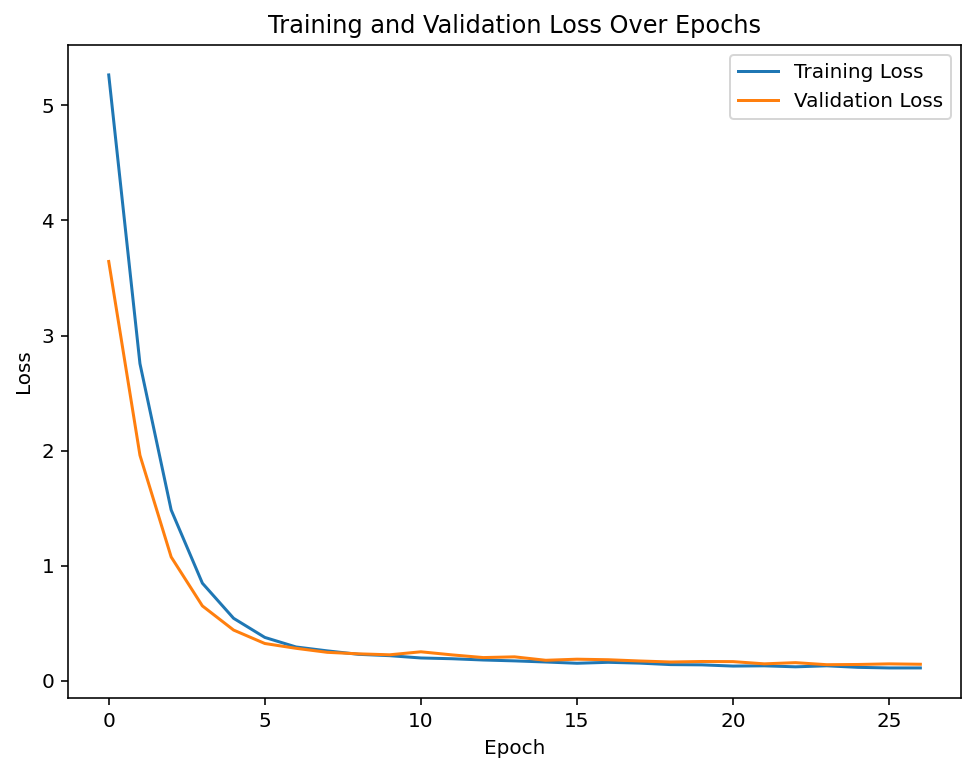

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(hisotry_2.history['loss'], label='Training Loss')
plt.plot(hisotry_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

6/6 [==============================] - 2s 18ms/step


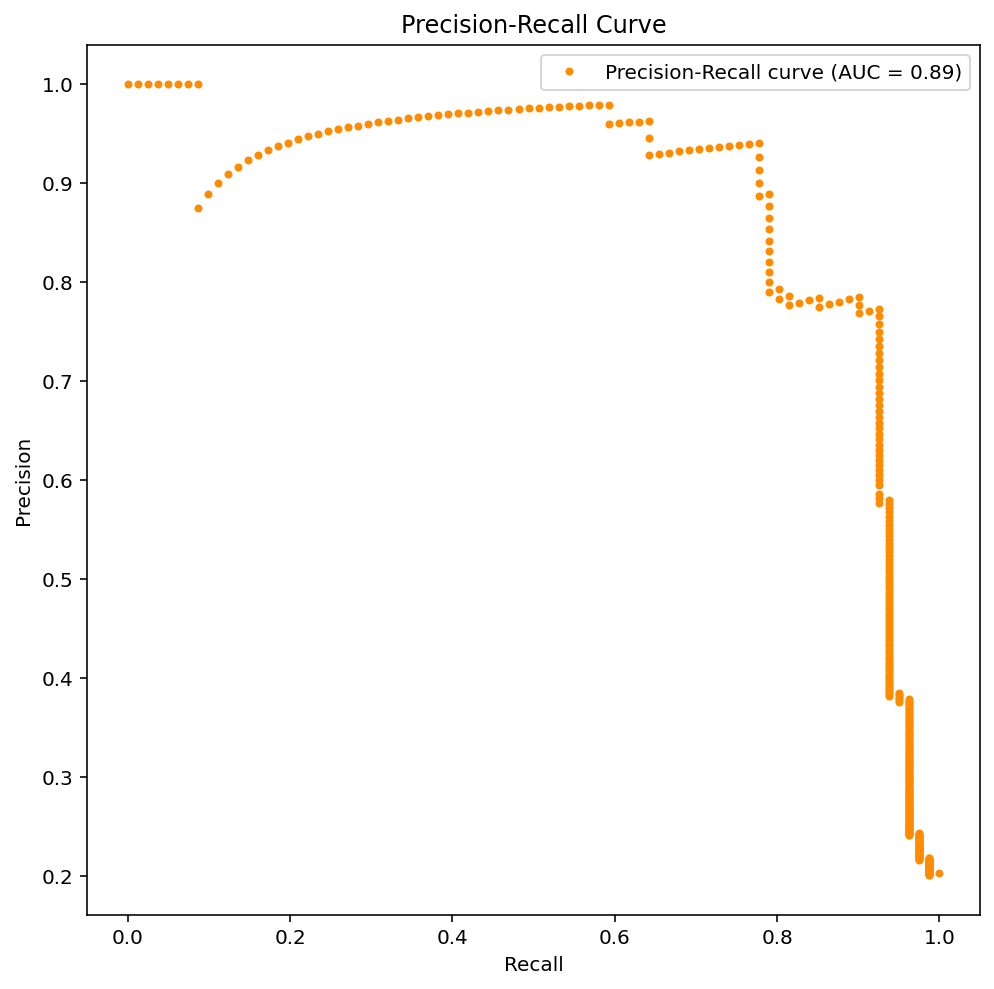

In [31]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

ds_r = val_ds_r

y_true = []
for x, y in ds_r:
    y_true.extend(y.numpy().flatten())

# Convert the target values to a NumPy array
y_true = np.array(y_true)
y_prob = model_2.predict(ds_r)


precision, recall, thresholds_pr = precision_recall_curve(y_true, y_prob)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, '.', color='darkorange', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
ds_r = val_ds_r

y_true = []
for x, y in ds_r:
    y_true.extend(y.numpy().flatten())

# Convert the target values to a NumPy array
y_true = np.array(y_true)
y_prob = model_2.predict(ds_r)

y_pred_optimal = (y_prob >= 0.3).astype(int)
conf_matrix = confusion_matrix(y_true, y_pred_optimal)
conf_matrix


6/6 [==============================] - 0s 18ms/step


array([[675,  12],
       [ 17,  64]])

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_gpu_lukaliu.kernel.lukaliu.3327872392464.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


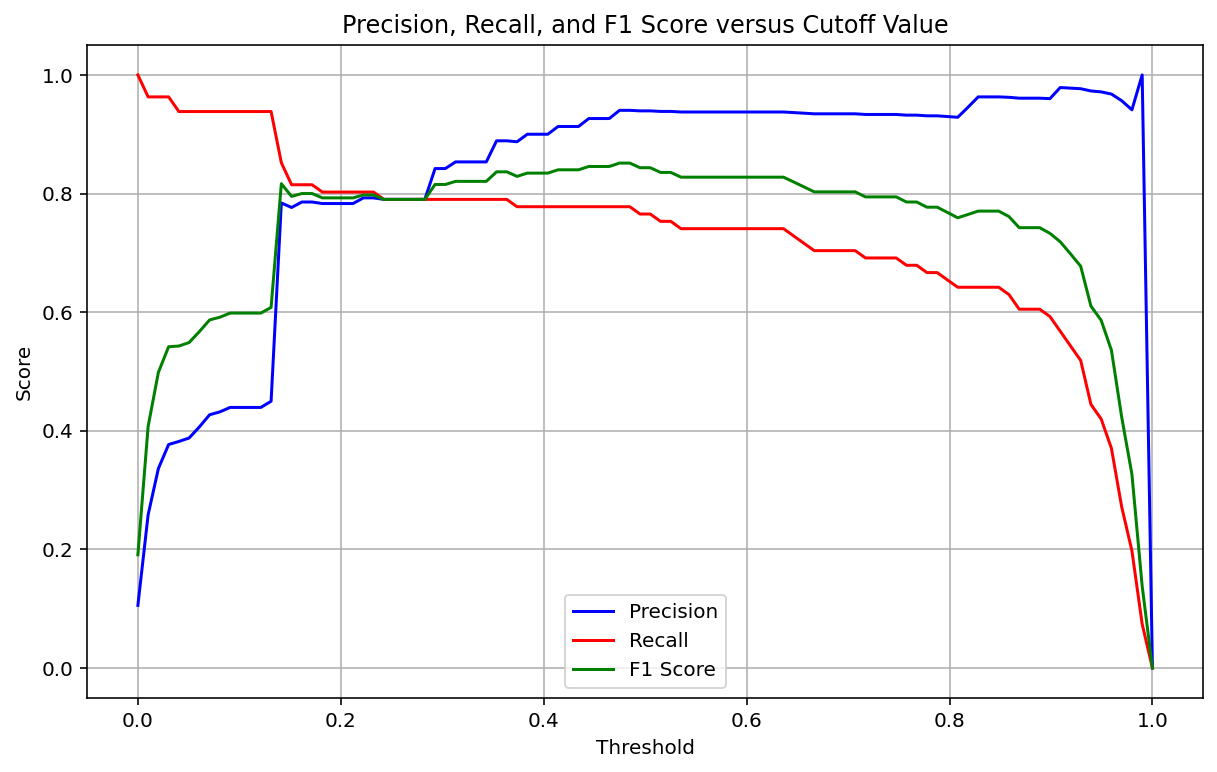

In [36]:

thresholds = np.linspace(0, 1, 100)
precision_scores = [precision_score(y_true, y_prob > threshold) for threshold in thresholds]
recall_scores = [recall_score(y_true, y_prob > threshold) for threshold in thresholds]
f1_scores = [f1_score(y_true, y_prob > threshold) for threshold in thresholds]

# Plot precision, recall, and F1 score versus cutoff value
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', color='blue')
plt.plot(thresholds, recall_scores, label='Recall', color='red')
plt.plot(thresholds, f1_scores, label='F1 Score', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score versus Cutoff Value')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
tf.keras.models.save_model(model_2, "model_3_v1")

In [39]:
!zip -r model_3_v1.zip model_3_v1


  adding: model_3_v1/ (stored 0%)
  adding: model_3_v1/saved_model.pb (deflated 94%)
  adding: model_3_v1/assets/ (stored 0%)
  adding: model_3_v1/variables/ (stored 0%)
  adding: model_3_v1/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: model_3_v1/variables/variables.index (deflated 23%)
  adding: model_3_v1/keras_metadata.pb (deflated 96%)
  adding: model_3_v1/fingerprint.pb (stored 0%)


In [40]:
%download_file model_3_v1.zip

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>